## **Exercise 2.1**

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from sklearn import tree

### Data Preprocessing

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/OmarAndujarL/Deep-Learning-Math514/main/shelter_data.csv')
df_cleaned=df.dropna()
x=df_cleaned[['AnimalType','SexuponOutcome']]
y=df_cleaned[['OutcomeType']]

#Transform AgeuponOutcome as float in years in stead of categorical
age=df_cleaned.AgeuponOutcome.to_list()
age_number=[]
for time in age:
    if 'year' in time.split():
        age_number.append(float(time.split()[0]))
    elif 'years' in time.split():
        age_number.append(float(time.split()[0]))
    
    elif 'month' in time.split():
        age_number.append(float(time.split()[0])/12)
    
    else:
        age_number.append(float(time.split()[0])/48)

#Encoding categorical varible from text to number
enc=OrdinalEncoder()
enc.fit(x)
le=LabelEncoder()
le.fit(y)

df_cat=pd.DataFrame(enc.transform(x),columns=list(x))
x=df_cat
x['AgeuponOutcome']=age_number

y=le.transform(y)
y=y.reshape(x.shape[0],1)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Decision Tree Training

In [3]:
clf_3=DecisionTreeClassifier(max_depth=3)
clf_3=clf_3.fit(x_train,y_train)
y_pred=clf_3.predict(x_test)
print('accuracy %2.2f ' % accuracy_score(y_test,y_pred))

accuracy 0.72 


In [4]:
dict(zip(np.unique(y).tolist(),le.inverse_transform(np.unique(y)).tolist()))

{0: 'Adoption', 1: 'Died', 2: 'Euthanasia', 3: 'Transfer'}

#### Confusion Matrix

In [5]:
cm=confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_pred))
labels=['Adoption','Died','Euthanasia','Transfer']
test_results = pd.DataFrame(cm,index=labels,columns=labels)
display(test_results)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Adoption,Died,Euthanasia,Transfer
Adoption,194,0,0,156
Died,1,0,0,13
Euthanasia,0,0,0,145
Transfer,71,0,0,816


Text(0.5, 1.0, 'Confusion Matrix for DCT(max_depth=3)')

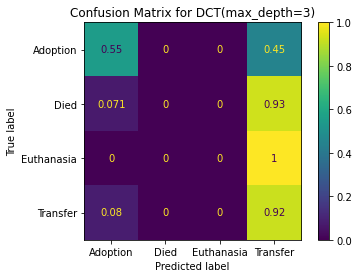

In [6]:
cm_cl3=ConfusionMatrixDisplay.from_estimator(clf_3,x_test,y_test,display_labels=test_results.columns.to_list(),normalize='true')
cm_cl3.ax_.set_title('Confusion Matrix for DCT(max_depth=3)')

#### Decision Tree Plot

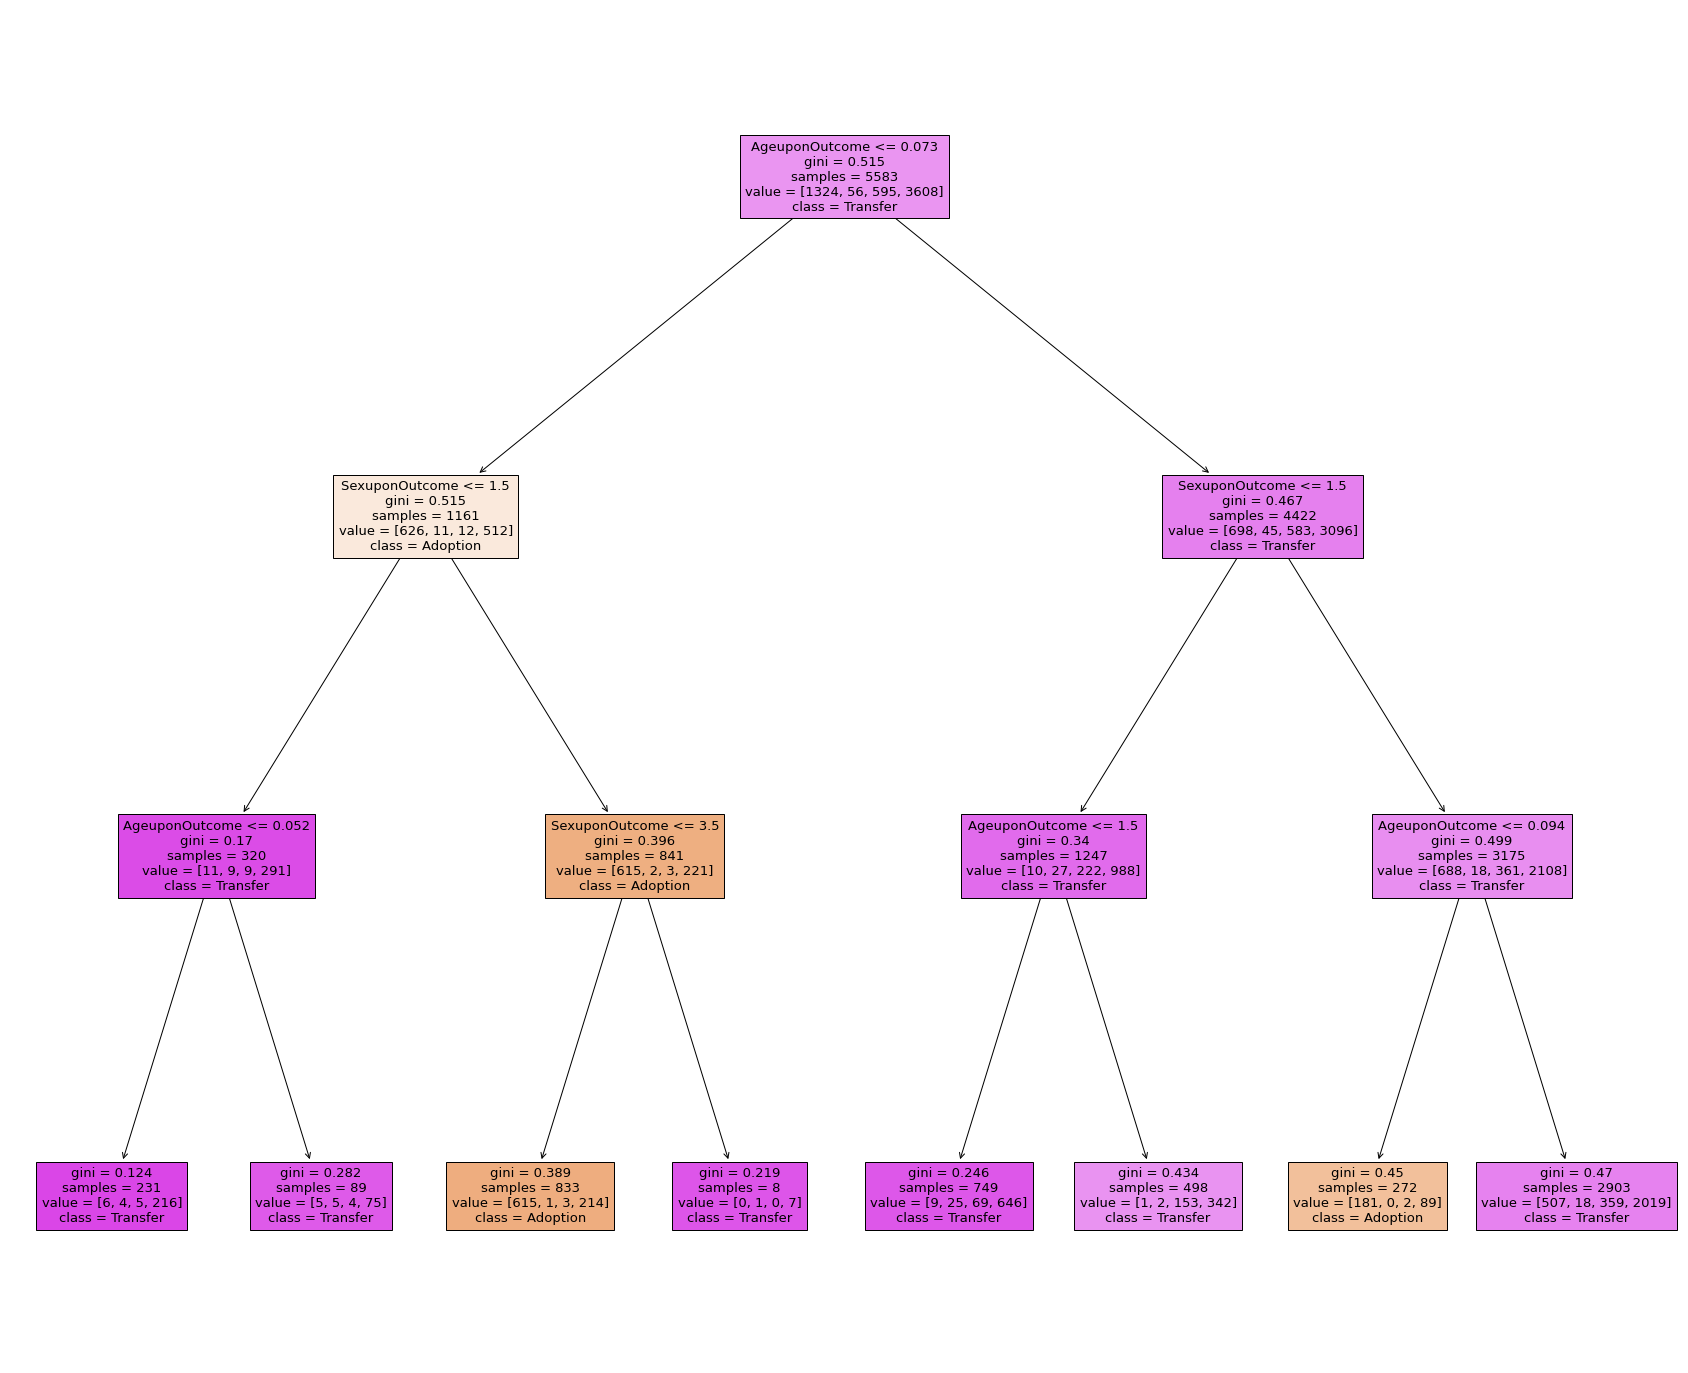

In [7]:
fig,ax=plt.subplots(figsize=(30,25))
treeplot=tree.plot_tree(clf_3,feature_names=x.columns.to_list(),
                        class_names=test_results.columns.to_list(),filled=True,ax=ax)

#### Max_Depth

Text(0, 0.5, 'Accuracy')

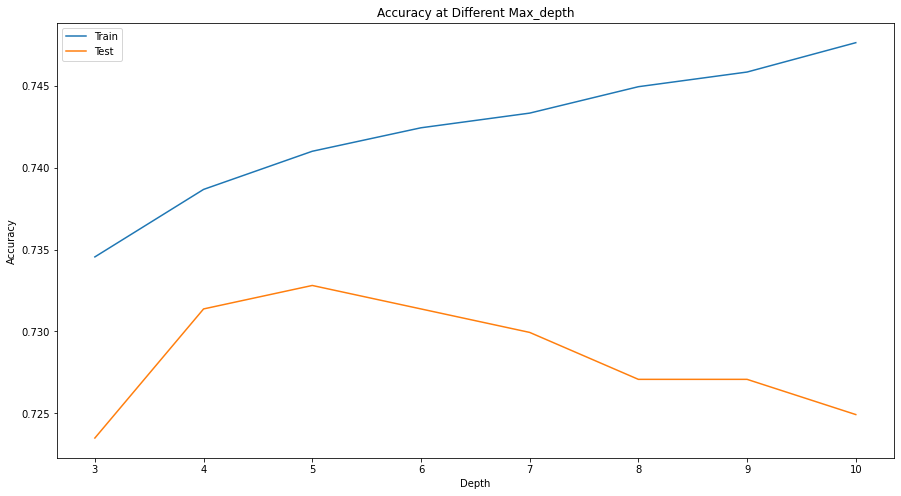

In [8]:
train_errors=[]
test_errors=[]

for i in range(3,11):
    clf=DecisionTreeClassifier(max_depth=i)
    clf=clf.fit(x_train,y_train)
    
    train_errors.append(accuracy_score(y_train,clf.predict(x_train)))
    test_errors.append(accuracy_score(y_test,clf.predict(x_test)))

plt.figure(figsize=(15,8))
plt.plot(range(3,11),train_errors,label='Train')
plt.plot(range(3,11),test_errors,label='Test')
plt.title('Accuracy at Different Max_depth')
plt.legend(loc=2)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
    

The plot is about train and test accuracy of DecisionTreeClassifier with different max_depth. 
Based on the graph, maxiumum depth at 5 gives the best test_score.

#### Ccp_alpha Pruning Factor

Text(0.5, 1.0, 'Total Impurity vs Ccp_alpha for Training Set at Max_depth=5')

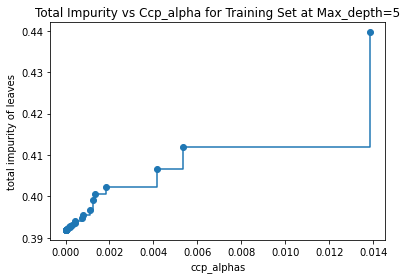

In [9]:
clf=DecisionTreeClassifier(max_depth=5)
path=clf.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas,impurities=path.ccp_alphas,path.impurities

fig,ax=plt.subplots()
ax.plot(ccp_alphas[:-1],impurities[:-1],marker='o',drawstyle='steps-post')
ax.set_xlabel('ccp_alphas')
ax.set_ylabel('total impurity of leaves')
ax.set_title("Total Impurity vs Ccp_alpha for Training Set at Max_depth=5")

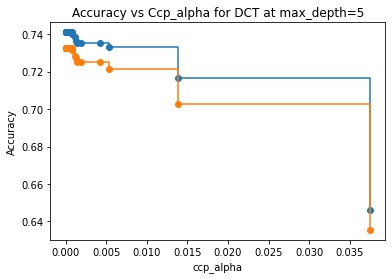

In [10]:
clfs=[]
for ccp_alpha in ccp_alphas:
    clf=DecisionTreeClassifier(ccp_alpha=ccp_alpha,max_depth=5)
    clf.fit(x_train,y_train)
    clfs.append(clf)

train_score=[clf.score(x_train,y_train) for clf in clfs]
test_score=[clf.score(x_test,y_test) for clf in clfs]

fig,ax=plt.subplots()
ax.set_xlabel('ccp_alpha')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Ccp_alpha for DCT at max_depth=5')

ax.plot(ccp_alphas,train_score,marker='o',label='train',drawstyle='steps-post')
ax.plot(ccp_alphas,test_score,marker='o',label='test',drawstyle='steps-post')




In [11]:
#Use mean of ccp_alphas as the pruning factor
clf=DecisionTreeClassifier(ccp_alpha=0.0007,max_depth=5)
clf.fit(x_train,y_train)
print('train accuracy: {0} and test accuracy{1}'.format(clf.score(x_train,y_train),clf.score(x_test,y_test)))

train accuracy: 0.7409994626544868 and test accuracy0.7328080229226361


based on previous plot, mean of ccp_alphas produces relatively good test and train accuracy.

### Pruned vs. Unpruned

In [12]:
clf_pruned=DecisionTreeClassifier(ccp_alpha=0.0007,max_depth=5)
clf_pruned.fit(x_train,y_train)

clf_unpruned=DecisionTreeClassifier(max_depth=5)
clf_unpruned.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5)

#### Pruned Tree

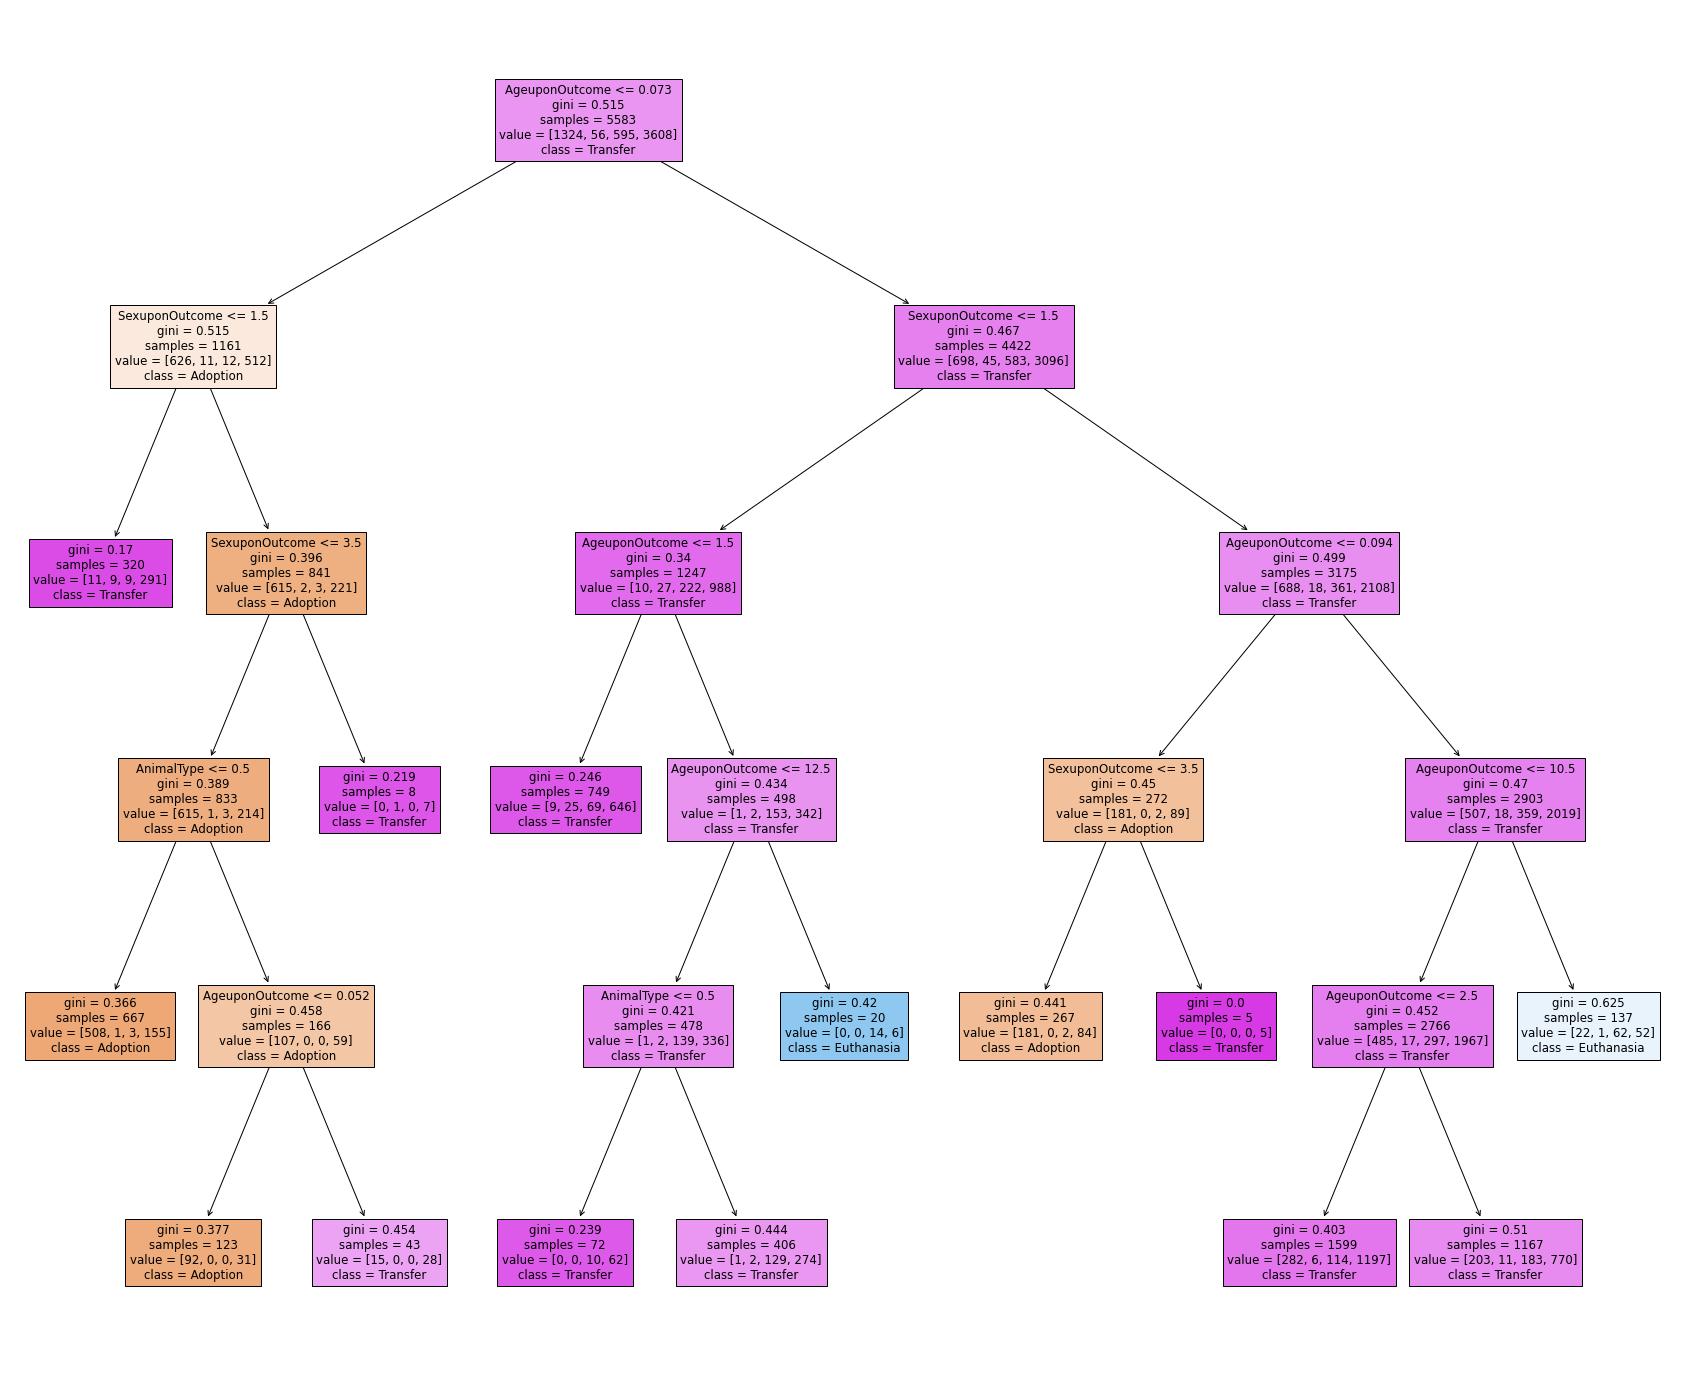

In [13]:
fig,ax=plt.subplots(figsize=(30,25))
treeplot=tree.plot_tree(clf_pruned,feature_names=x.columns.to_list(),
                        class_names=test_results.columns.to_list(),filled=True,ax=ax)

#### Pruned Test Accuracy vs. Unpruned Test Accuracy

In [14]:
print ('Accuracy on Test Set with Pruning {0}\nAccuracy on Test Set without pruning {1}'.format(clf_pruned.score(x_test,y_test),clf_unpruned.score(x_test,y_test)))

Accuracy on Test Set with Pruning 0.7328080229226361
Accuracy on Test Set without pruning 0.7328080229226361


#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix for Unpruned DCT')

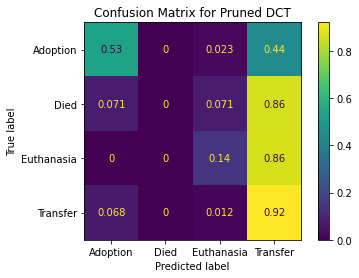

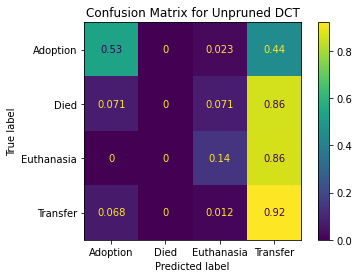

In [15]:
y_pred_pruned=clf_pruned.predict(x_test)
y_pred_unpruned=clf_unpruned.predict(x_test)

cm_pruned=ConfusionMatrixDisplay.from_estimator(clf_pruned,x_test,y_test,display_labels=test_results.columns.to_list(),normalize='true')
cm_pruned.ax_.set_title('Confusion Matrix for Pruned DCT')

cm_unpruned=ConfusionMatrixDisplay.from_estimator(clf_unpruned,x_test,y_test,display_labels=test_results.columns.to_list(),normalize='true')
cm_unpruned.ax_.set_title('Confusion Matrix for Unpruned DCT')

## **Exercise 2.2**

### **Imports/Setup**

In [16]:
import sys
assert sys.version_info >= (3, 7)

In [17]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [18]:
import pandas as pd

url = 'https://raw.githubusercontent.com/OmarAndujarL/Deep-Learning-Math514/main/text_data.csv'
df = pd.read_csv(url)
df = df.dropna()

df.head()

,Unnamed: 0,meta_author,meta_title,000,10,11,13,136,13th,1648,...,yielding,yoke,yokes,york,young,yourselves,zaleucus,zeal,zealand,zealous
0,0,hamilton,general introduction for the independent journ...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,3,0,0
1,1,jay,concerning dangers from foreign force and infl...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,jay,the same subject continued concerning dangers ...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,jay,the same subject continued concerning dangers ...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4,jay,the same subject continued concerning dangers ...,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0


### **Split into train/test data**

In [19]:
from sklearn.model_selection import train_test_split

# copy word counts as X variables, copy author as y variable

X = df.iloc[:,3:].copy()
y = df['meta_author'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [20]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from matplotlib import pyplot as plt

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
a = metrics.accuracy_score(y_train, y_pred)

y_pred2 = clf.predict(X_test)
b = metrics.accuracy_score(y_test, y_pred2)

print("Train accuracy no parameters ", ": ", a)
print("Test accuracy no parameters ", ": ", b)


Train accuracy no parameters  :  1.0
Test accuracy no parameters  :  0.6666666666666666


### **Decision tree 1 and accuracy plot**

Train accuracy for depth  1 :  0.7368421052631579
Test accuracy for depth  1 :  0.3333333333333333
Train accuracy for depth  2 :  0.8552631578947368
Test accuracy for depth  2 :  0.2222222222222222
Train accuracy for depth  3 :  0.9342105263157895
Test accuracy for depth  3 :  0.6666666666666666
Train accuracy for depth  4 :  0.9868421052631579
Test accuracy for depth  4 :  0.5555555555555556
Train accuracy for depth  5 :  1.0
Test accuracy for depth  5 :  0.5555555555555556
Train accuracy for depth  6 :  1.0
Test accuracy for depth  6 :  0.2222222222222222
Train accuracy for depth  7 :  1.0
Test accuracy for depth  7 :  0.2222222222222222
Train accuracy for depth  8 :  1.0
Test accuracy for depth  8 :  0.6666666666666666
Train accuracy for depth  9 :  1.0
Test accuracy for depth  9 :  0.6666666666666666
Train accuracy for depth  10 :  1.0
Test accuracy for depth  10 :  0.6666666666666666
Train accuracy for depth  11 :  1.0
Test accuracy for depth  11 :  0.3333333333333333
Train accura

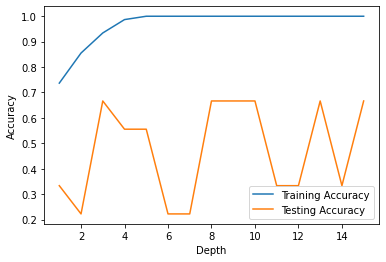

In [21]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from matplotlib import pyplot as plt

depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_accuracy = []
test_accuracy = []

for i in depth:
  clf = tree.DecisionTreeClassifier(max_depth = i)
  clf = clf.fit(X_train, y_train)

  y_pred = clf.predict(X_train)
  a = metrics.accuracy_score(y_train, y_pred)
  train_accuracy.append(a)

  y_pred2 = clf.predict(X_test)
  b = metrics.accuracy_score(y_test, y_pred2)
  test_accuracy.append(b)

  print("Train accuracy for depth ", i, ": ", a)
  print("Test accuracy for depth ", i, ": ", b)


plt.plot(depth, train_accuracy, label='Training Accuracy')
plt.plot(depth, test_accuracy, label='Testing Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **Decision tree 2 and accuracy plot - words used once**

In [22]:
text_frequecies = X.sum()
text_frequecies.sort_values()

kept_words = text_frequecies[text_frequecies<2]

small_vocab_X = X[kept_words.index]
display(small_vocab_X)

kept_vector = []
small_cols = small_vocab_X.columns.values
all_cols = X.columns.values

for i in all_cols:
  if i in small_cols:
    kept_vector.append(1)
  else:
    kept_vector.append(0)

small_vocab_y = y.copy()
for i in kept_vector:
  if i == 0:
    small_vocab_y.drop(index=small_vocab_y.index[i])

display(small_vocab_y)

,13,136,13th,1648,1683,1685,1706,1726,1774,1786,...,wrongs,wyoming,xv,yates,yeomanry,yes,yokes,yourselves,zaleucus,zealand
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


0     hamilton
1          jay
2          jay
3          jay
4          jay
        ...   
80    hamilton
81    hamilton
82    hamilton
83    hamilton
84    hamilton
Name: meta_author, Length: 85, dtype: object

In [23]:
X_train, X_test, y_train, y_test = train_test_split(small_vocab_X, small_vocab_y, test_size = 0.1, random_state=42)

Train accuracy for depth  1 :  0.5921052631578947
Test accuracy for depth  1 :  0.7777777777777778
Train accuracy for depth  2 :  0.6052631578947368
Test accuracy for depth  2 :  0.7777777777777778
Train accuracy for depth  3 :  0.618421052631579
Test accuracy for depth  3 :  0.7777777777777778
Train accuracy for depth  4 :  0.631578947368421
Test accuracy for depth  4 :  0.7777777777777778
Train accuracy for depth  5 :  0.6447368421052632
Test accuracy for depth  5 :  0.7777777777777778
Train accuracy for depth  6 :  0.6578947368421053
Test accuracy for depth  6 :  0.7777777777777778
Train accuracy for depth  7 :  0.6710526315789473
Test accuracy for depth  7 :  0.7777777777777778
Train accuracy for depth  8 :  0.6842105263157895
Test accuracy for depth  8 :  0.7777777777777778
Train accuracy for depth  9 :  0.6973684210526315
Test accuracy for depth  9 :  0.7777777777777778
Train accuracy for depth  10 :  0.7105263157894737
Test accuracy for depth  10 :  0.7777777777777778
Train accu

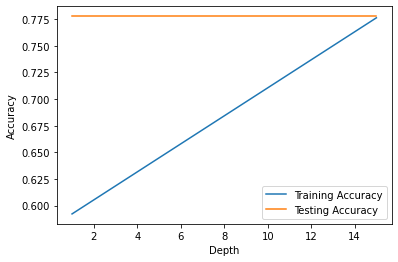

In [24]:
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_accuracy = []
test_accuracy = []

for i in depth:
  clf = tree.DecisionTreeClassifier(max_depth = i)
  clf = clf.fit(X_train, y_train)

  y_pred = clf.predict(X_train)
  a = metrics.accuracy_score(y_train, y_pred)
  train_accuracy.append(a)

  y_pred2 = clf.predict(X_test)
  b = metrics.accuracy_score(y_test, y_pred2)
  test_accuracy.append(b)

  print("Train accuracy for depth ", i, ": ", a)
  print("Test accuracy for depth ", i, ": ", b)


plt.plot(depth, train_accuracy, label='Training Accuracy')
plt.plot(depth, test_accuracy, label='Testing Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **Decision tree 3 and accuracy plot - words used >100 times**

In [25]:
text_frequecies = X.sum()
text_frequecies.sort_values()

kept_words = text_frequecies[text_frequecies>100]

large_vocab_X = X[kept_words.index]
display(large_vocab_X)

kept_vector = []
large_cols = large_vocab_X.columns.values
all_cols = X.columns.values

for i in all_cols:
  if i in large_cols:
    kept_vector.append(1)
  else:
    kept_vector.append(0)

large_vocab_y = y.copy()
for i in kept_vector:
  if i == 0:
    large_vocab_y.drop(index=large_vocab_y.index[i])

print(large_vocab_y)

,against,all,america,among,another,any,authority,being,between,body,...,well,what,when,where,whether,whole,within,without,yet,york
0,2,9,1,1,1,6,0,1,0,1,...,4,0,1,0,2,1,0,0,1,1
1,1,4,7,2,0,1,0,3,0,1,...,6,2,4,0,1,0,0,2,3,1
2,3,4,6,1,0,5,0,1,0,0,...,7,0,1,0,3,1,0,0,3,1
3,6,4,5,0,1,5,0,1,2,0,...,4,7,4,0,2,6,0,2,0,1
4,5,4,5,0,4,3,0,3,3,0,...,1,2,1,0,2,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,6,13,0,0,4,15,8,3,4,12,...,7,2,2,3,1,1,2,6,4,2
81,0,7,0,0,2,1,9,2,2,0,...,1,2,1,4,1,3,1,2,1,2
82,6,28,0,1,5,16,5,5,9,5,...,5,2,1,7,2,2,2,6,5,5
83,8,14,2,3,6,32,1,1,2,4,...,7,11,5,4,1,2,1,6,4,3


0     hamilton
1          jay
2          jay
3          jay
4          jay
        ...   
80    hamilton
81    hamilton
82    hamilton
83    hamilton
84    hamilton
Name: meta_author, Length: 85, dtype: object


In [26]:
X_train, X_test, y_train, y_test = train_test_split(large_vocab_X, large_vocab_y, test_size = 0.1, random_state=42)

Train accuracy for depth  1 :  0.6973684210526315
Test accuracy for depth  1 :  0.6666666666666666
Train accuracy for depth  2 :  0.8157894736842105
Test accuracy for depth  2 :  0.7777777777777778
Train accuracy for depth  3 :  0.8947368421052632
Test accuracy for depth  3 :  0.7777777777777778
Train accuracy for depth  4 :  0.9078947368421053
Test accuracy for depth  4 :  0.7777777777777778
Train accuracy for depth  5 :  0.9736842105263158
Test accuracy for depth  5 :  0.7777777777777778
Train accuracy for depth  6 :  0.9868421052631579
Test accuracy for depth  6 :  0.7777777777777778
Train accuracy for depth  7 :  0.9868421052631579
Test accuracy for depth  7 :  0.7777777777777778
Train accuracy for depth  8 :  1.0
Test accuracy for depth  8 :  0.7777777777777778
Train accuracy for depth  9 :  1.0
Test accuracy for depth  9 :  0.6666666666666666
Train accuracy for depth  10 :  1.0
Test accuracy for depth  10 :  0.7777777777777778
Train accuracy for depth  11 :  1.0
Test accuracy for

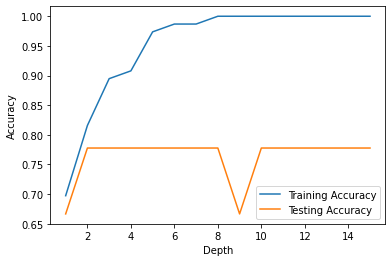

In [27]:
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_accuracy = []
test_accuracy = []

for i in depth:
  clf = tree.DecisionTreeClassifier(max_depth = i)
  clf = clf.fit(X_train, y_train)

  y_pred = clf.predict(X_train)
  a = metrics.accuracy_score(y_train, y_pred)
  train_accuracy.append(a)

  y_pred2 = clf.predict(X_test)
  b = metrics.accuracy_score(y_test, y_pred2)
  test_accuracy.append(b)

  print("Train accuracy for depth ", i, ": ", a)
  print("Test accuracy for depth ", i, ": ", b)


plt.plot(depth, train_accuracy, label='Training Accuracy')
plt.plot(depth, test_accuracy, label='Testing Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Exercise 2.3**

In [28]:
import sys
assert sys.version_info >= (3, 7)

In [29]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

### **Import the data**

In [30]:
import pandas as pd

def load_data():
  url = 'https://raw.githubusercontent.com/OmarAndujarL/Deep-Learning-Math514/main/audio_data.csv'  #Audio data imported from github
  df = pd.read_csv(url)
  return df

df = load_data()
display(df.head())
display(df.describe())

,Unnamed: 0,filename,label_text,label,0.00 hz,86.13 hz,172.27 hz,258.40 hz,344.53 hz,430.66 hz,...,10249.80 hz,10335.94 hz,10422.07 hz,10508.20 hz,10594.34 hz,10680.47 hz,10766.60 hz,10852.73 hz,10938.87 hz,11025.00 hz
0,0,70Funk.wav,snare,0,0.117469,0.201065,3.666227,7.554432,5.356165,2.470225,...,0.000272,0.000199,0.000083,0.000071,0.000068,0.000041,0.000003,5.277616e-07,1.054685e-07,7.286777e-09
1,1,8oh8 Rim.wav,snare,0,0.003148,0.012814,0.375678,1.050320,0.164903,0.089524,...,0.001122,0.000737,0.000304,0.000211,0.000128,0.000036,0.000006,1.266412e-06,1.366164e-07,3.532417e-09
2,2,8oh8 Tin.wav,snare,0,0.006759,0.039368,0.385903,0.254091,0.086651,0.137728,...,0.000633,0.000391,0.000169,0.000128,0.000074,0.000024,0.000003,7.285032e-07,7.223851e-08,2.491626e-09
3,3,8oh8 Snr.wav,snare,0,0.003083,0.001359,0.021241,0.053261,0.026645,0.393541,...,0.004249,0.002850,0.001079,0.000781,0.000527,0.000161,0.000024,5.044927e-06,5.018216e-07,5.197483e-08
4,4,9oh9 Rim.wav,snare,0,0.006571,0.007394,0.033357,0.458574,1.056414,0.435841,...,0.000267,0.000211,0.000077,0.000065,0.000033,0.000008,0.000003,7.358946e-07,4.149365e-08,3.860568e-09


,Unnamed: 0,label,0.00 hz,86.13 hz,172.27 hz,258.40 hz,344.53 hz,430.66 hz,516.80 hz,602.93 hz,...,10249.80 hz,10335.94 hz,10422.07 hz,10508.20 hz,10594.34 hz,10680.47 hz,10766.60 hz,10852.73 hz,10938.87 hz,11025.00 hz
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02
mean,105.500000,0.448113,3.624958,17.416965,8.596787,3.566502,1.000167,0.591471,0.458107,0.272973,...,5.081631e-04,3.644158e-04,2.388318e-04,1.298940e-04,5.193798e-05,1.519868e-05,3.533626e-06,6.712768e-07,9.091606e-08,6.313396e-09
std,61.343296,0.498478,6.942545,26.438515,9.235777,4.788102,1.544003,1.183579,1.033818,0.438555,...,8.586429e-04,6.526129e-04,4.844244e-04,2.545205e-04,1.072925e-04,3.001521e-05,6.106023e-06,1.313119e-06,1.898266e-07,1.143963e-08
min,0.000000,0.000000,0.001527,0.000948,0.003451,0.023271,0.004121,0.001391,0.000347,0.000163,...,3.621452e-08,3.443271e-08,1.849979e-08,5.991134e-09,4.987205e-09,8.123556e-10,3.550325e-10,8.939242e-11,8.800568e-12,5.490084e-13
25%,52.750000,0.000000,0.064840,0.217712,2.332045,0.336935,0.076210,0.037117,0.017721,0.012821,...,4.174945e-06,2.944346e-06,1.856348e-06,8.194084e-07,2.636999e-07,1.042592e-07,1.984290e-08,3.470632e-09,4.616096e-10,5.699681e-11
50%,105.500000,0.000000,0.488410,3.617768,6.081414,1.707556,0.459056,0.260691,0.202617,0.118620,...,1.162325e-04,8.833813e-05,5.552127e-05,2.563628e-05,1.019511e-05,3.744049e-06,9.070992e-07,1.677709e-07,1.739184e-08,1.160822e-09
75%,158.250000,1.000000,4.309501,24.334535,11.312375,4.999953,1.197420,0.630419,0.550811,0.378223,...,6.407021e-04,4.739844e-04,2.912185e-04,1.680799e-04,6.742486e-05,1.851275e-05,4.349353e-06,7.235192e-07,9.673274e-08,7.282709e-09
max,211.000000,1.000000,66.582860,190.067730,56.203686,31.318716,10.232034,12.798109,12.753410,3.378856,...,5.823903e-03,4.541307e-03,3.899693e-03,2.203800e-03,7.747787e-04,2.575438e-04,4.113468e-05,9.834714e-06,1.392894e-06,7.029924e-08


### **Clean the data**

Check columns that are not float

In [31]:
df.select_dtypes(exclude=['float64']).head() 

,Unnamed: 0,filename,label_text,label
0,0,70Funk.wav,snare,0
1,1,8oh8 Rim.wav,snare,0
2,2,8oh8 Tin.wav,snare,0
3,3,8oh8 Snr.wav,snare,0
4,4,9oh9 Rim.wav,snare,0


Check if dataframe has null values

In [32]:
df[df.isna().any(axis=1)]   

,Unnamed: 0,filename,label_text,label,0.00 hz,86.13 hz,172.27 hz,258.40 hz,344.53 hz,430.66 hz,...,10249.80 hz,10335.94 hz,10422.07 hz,10508.20 hz,10594.34 hz,10680.47 hz,10766.60 hz,10852.73 hz,10938.87 hz,11025.00 hz


Drop null values 

In [33]:
df = df.dropna()   
df.head()

,Unnamed: 0,filename,label_text,label,0.00 hz,86.13 hz,172.27 hz,258.40 hz,344.53 hz,430.66 hz,...,10249.80 hz,10335.94 hz,10422.07 hz,10508.20 hz,10594.34 hz,10680.47 hz,10766.60 hz,10852.73 hz,10938.87 hz,11025.00 hz
0,0,70Funk.wav,snare,0,0.117469,0.201065,3.666227,7.554432,5.356165,2.470225,...,0.000272,0.000199,0.000083,0.000071,0.000068,0.000041,0.000003,5.277616e-07,1.054685e-07,7.286777e-09
1,1,8oh8 Rim.wav,snare,0,0.003148,0.012814,0.375678,1.050320,0.164903,0.089524,...,0.001122,0.000737,0.000304,0.000211,0.000128,0.000036,0.000006,1.266412e-06,1.366164e-07,3.532417e-09
2,2,8oh8 Tin.wav,snare,0,0.006759,0.039368,0.385903,0.254091,0.086651,0.137728,...,0.000633,0.000391,0.000169,0.000128,0.000074,0.000024,0.000003,7.285032e-07,7.223851e-08,2.491626e-09
3,3,8oh8 Snr.wav,snare,0,0.003083,0.001359,0.021241,0.053261,0.026645,0.393541,...,0.004249,0.002850,0.001079,0.000781,0.000527,0.000161,0.000024,5.044927e-06,5.018216e-07,5.197483e-08
4,4,9oh9 Rim.wav,snare,0,0.006571,0.007394,0.033357,0.458574,1.056414,0.435841,...,0.000267,0.000211,0.000077,0.000065,0.000033,0.000008,0.000003,7.358946e-07,4.149365e-08,3.860568e-09


Check how many labels there are

In [34]:
df['label_text'].unique()  

array(['snare', 'kick'], dtype=object)

### **Apply machine learning model**

#### **Import necessary libraries**

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, classification_report
from sklearn import tree
from matplotlib import pyplot as plt
import numpy as np


### **Apply train-test split**

In [36]:
X = df.iloc[:,4:].copy()  #only numerical values
y = df['label'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)  

#### **Plot accuracy vs depth (1 to 15)**

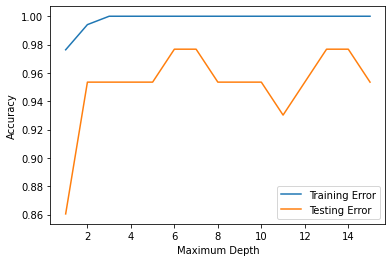

In [37]:
max_depth_list = np.arange(1,16,1)
train_errors = []
accuracy_list_test = []
accuracy_list_train = []

for ele in max_depth_list:
  clf = DecisionTreeClassifier(max_depth=ele)  #ccp_alpha prunes the tree. Default value is 0. ccp_alpha=0.01
  clf = clf.fit(X_train, y_train)
  parameters = clf.get_params()
  #Test prediction
  test_predictions = clf.predict(X_test)                 #Make predictions
  probabilities_test = clf.predict_proba(X_test)         #Compute probabilities of those predictions
  accuracy_test = accuracy_score(y_test, test_predictions)
  accuracy_list_test.append(accuracy_test)

  #Train prediction
  train_predictions = clf.predict(X_train)
  probabilities_train = clf.predict_proba(X_train)
  accuracy_train = accuracy_score(y_train, train_predictions)
  accuracy_list_train.append(accuracy_train)

  #Print confusion matrix for test prediction
  #print(f'Confusion matrix for test prediction and depth {ele}')
  #display(confusion_matrix(y_test, test_predictions, labels = [0,1]))


plt.plot(max_depth_list, accuracy_list_train, label='Training Error') # Plot training error over domain
plt.plot(max_depth_list, accuracy_list_test, label='Testing Error') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.ylabel('Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.show() # Show graph
  

#### **Set depth=5**

              precision    recall  f1-score   support

       snare       1.00      0.90      0.95        21
        kick       0.92      1.00      0.96        22

    accuracy                           0.95        43
   macro avg       0.96      0.95      0.95        43
weighted avg       0.96      0.95      0.95        43



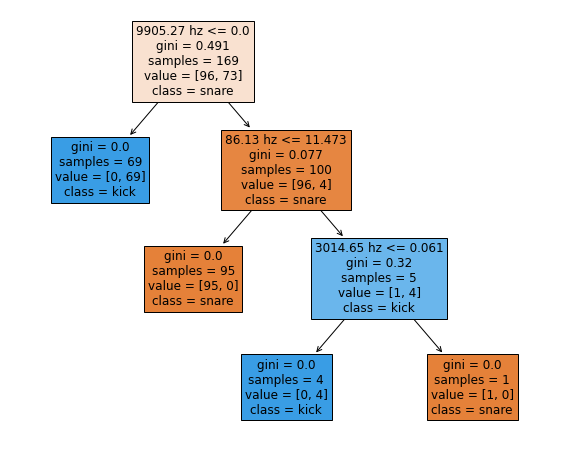

In [38]:
clf1 = DecisionTreeClassifier(max_depth=5)  #5 decisions. #ccp_alpha prunes the tree. Default value is 0.   ccp_alpha=0.01
clf1 = clf1.fit(X_train, y_train)
feature_names = X.columns
test_predictions = clf1.predict(X_test)                 #Make predictions
probabilities_test = clf1.predict_proba(X_test)         #Compute probabilities of those predictions
accuracy_test = accuracy_score(y_test, test_predictions)
print(classification_report(y_test, test_predictions, target_names=['snare', 'kick']))

fig1 = plt.figure(figsize=(10,8))
_ = tree.plot_tree(
    clf1,
    feature_names = feature_names,
    class_names = {0:'snare', 1:'kick'},
    filled = True,
    fontsize = 12
)

**Feature importance bar chart**

<AxesSubplot:>

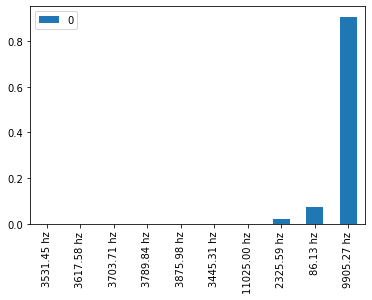

In [39]:
feature_df = pd.DataFrame(clf.feature_importances_, index = feature_names)
feature_importance = feature_df.sort_values(by = feature_df.columns.values[0])
feature_importance.tail(10).plot(kind='bar')

#### **New decision tree dropping a training row**

In [40]:
#Drop one training example from the data set
X = df.iloc[:,4:].copy()  #only numerical values
X_dropped = X.drop(1)     #Drop one row of Dataframe
y = df['label'].copy()
y = pd.Series(y)
y_dropped = y.drop(1)    #Drop one row of labels column
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y_dropped, test_size = 0.20, random_state=42)  #New split with modified data

New decision tree. Depth = 5

              precision    recall  f1-score   support

       snare       0.91      1.00      0.95        21
        kick       1.00      0.91      0.95        22

    accuracy                           0.95        43
   macro avg       0.96      0.95      0.95        43
weighted avg       0.96      0.95      0.95        43



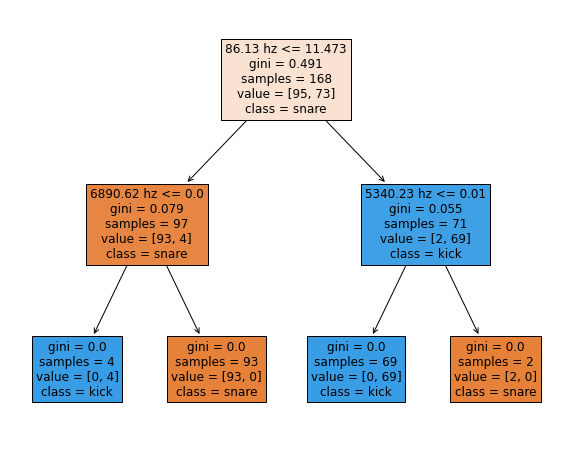

In [41]:
clf2 = DecisionTreeClassifier(max_depth=5) 
clf2 = clf2.fit(X_train, y_train)
feature_names = X.columns
test_predictions = clf2.predict(X_test)                 #Make predictions
probabilities_test = clf2.predict_proba(X_test)         #Compute probabilities of those predictions
accuracy_test = accuracy_score(y_test, test_predictions)
print(classification_report(y_test, test_predictions, target_names=['snare', 'kick']))

fig2 = plt.figure(figsize=(10,8))
_ = tree.plot_tree(
    clf2,
    feature_names = feature_names,
    class_names = {0:'snare', 1:'kick'},
    filled = True,
    fontsize = 12
)

**Decision tree depth 5 (original vs modified)**

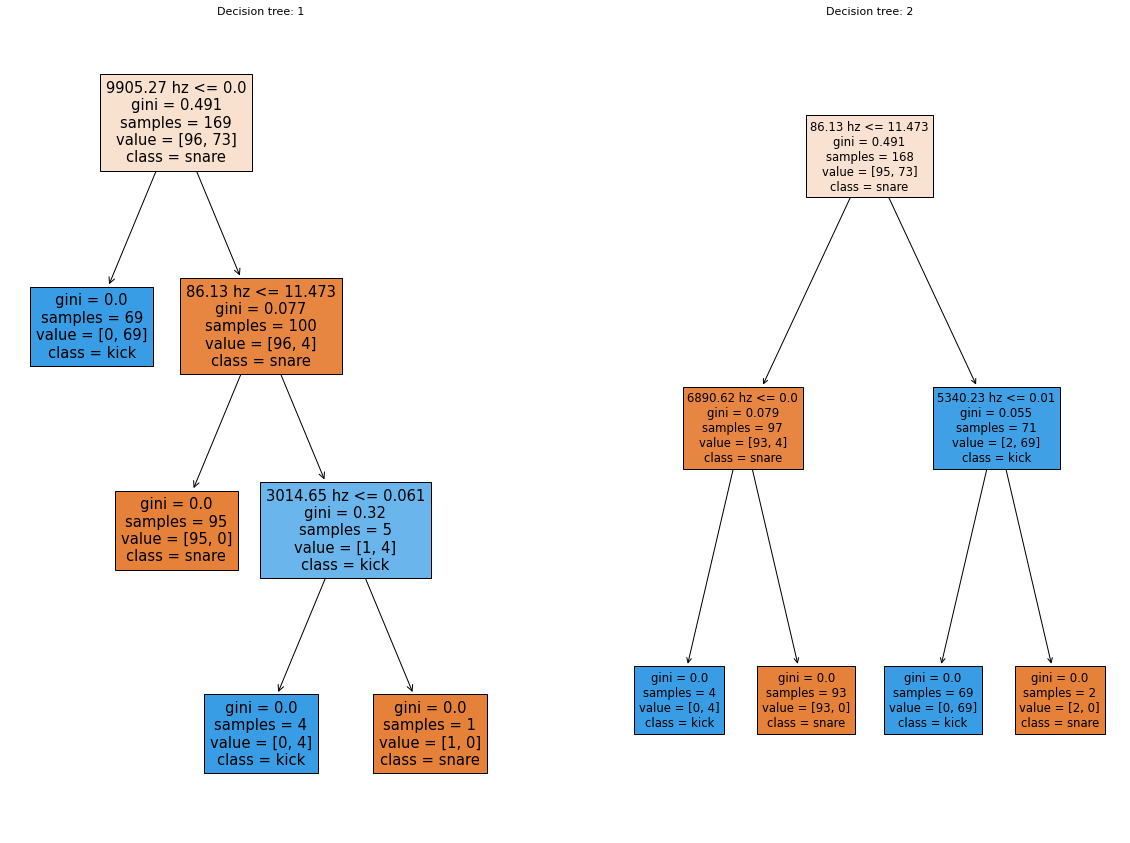

In [42]:
cfs = [clf1, clf2]            

fig, axes = plt.subplots(nrows = 1,ncols = 2,figsize = (20,15))
for index in range(0, 2):
    tree.plot_tree(cfs[index],
                   feature_names = feature_names, 
                   class_names={0:'snare', 1:'kick'},
                   filled = True,
                   ax = axes[index]);
    
    axes[index].set_title('Decision tree: ' + str(index+1), fontsize = 11)
fig.show()